# Importing the Libraries

In [1]:
# PySpark Core
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, when, isnan, lit, mean, sum as pysum, count, regexp_replace
from pyspark.sql.types import DoubleType

# PySpark ML
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Numerik & DataFrame Pandas
import numpy as np
import pandas as pd

# Sklearn metrics
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, 
    f1_score, recall_score, precision_score
)

# Load Dataset
#### Data: https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset


In [2]:
# Inisialisasi Spark Session
spark = SparkSession.builder.appName("BigDataProject").config("spark.driver.memory", "4g").config("spark.sql.shuffle.partitions", "200").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Load Data
df = spark.read.csv("*.csv", header=True, inferSchema=True)

# Membuat kolom BinaryLabel
df = df.withColumn(
    "BinaryLabel",
    when(col(" Label") == "BENIGN", "Normal").otherwise("Attack")
)

print("\n=== TOTAL GABUNGAN ===")
print(f"{df.count():,} baris")
print(f"Jumlah Kolom: {len(df.columns)}")

print("\n=== Distribusi Binary Label ===")
df.groupBy("BinaryLabel").count().show()

25/11/27 08:32:48 WARN Utils: Your hostname, dafa-Aspire-A514-55G resolves to a loopback address: 127.0.1.1; using 192.168.50.157 instead (on interface wlp43s0)
25/11/27 08:32:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/27 08:32:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                


=== TOTAL GABUNGAN ===


2,830,743 baris
Jumlah Kolom: 80

=== Distribusi Binary Label ===


[Stage 5:====================================================>    (12 + 1) / 13]

+-----------+-------+
|BinaryLabel|  count|
+-----------+-------+
|     Attack| 557646|
|     Normal|2273097|
+-----------+-------+



# Data Cleaning

In [3]:
# konversi data ke pandas untuk visualisasi
pdf = df.limit(5).toPandas()
pdf

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,BinaryLabel
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Normal
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Normal
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Normal
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Normal
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Normal


In [4]:
df.printSchema()

root
 |--  Destination Port: integer (nullable = true)
 |--  Flow Duration: integer (nullable = true)
 |--  Total Fwd Packets: integer (nullable = true)
 |--  Total Backward Packets: integer (nullable = true)
 |-- Total Length of Fwd Packets: integer (nullable = true)
 |--  Total Length of Bwd Packets: integer (nullable = true)
 |--  Fwd Packet Length Max: integer (nullable = true)
 |--  Fwd Packet Length Min: integer (nullable = true)
 |--  Fwd Packet Length Mean: double (nullable = true)
 |--  Fwd Packet Length Std: double (nullable = true)
 |-- Bwd Packet Length Max: integer (nullable = true)
 |--  Bwd Packet Length Min: integer (nullable = true)
 |--  Bwd Packet Length Mean: double (nullable = true)
 |--  Bwd Packet Length Std: double (nullable = true)
 |-- Flow Bytes/s: double (nullable = true)
 |--  Flow Packets/s: double (nullable = true)
 |--  Flow IAT Mean: double (nullable = true)
 |--  Flow IAT Std: double (nullable = true)
 |--  Flow IAT Max: integer (nullable = true)
 |-- 

In [5]:
#Menghapus spasi di awal dan akhir nama kolom
for column_name in df.columns:
    df = df.withColumnRenamed(column_name, column_name.strip())


In [6]:
df.printSchema()

root
 |-- Destination Port: integer (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Total Fwd Packets: integer (nullable = true)
 |-- Total Backward Packets: integer (nullable = true)
 |-- Total Length of Fwd Packets: integer (nullable = true)
 |-- Total Length of Bwd Packets: integer (nullable = true)
 |-- Fwd Packet Length Max: integer (nullable = true)
 |-- Fwd Packet Length Min: integer (nullable = true)
 |-- Fwd Packet Length Mean: double (nullable = true)
 |-- Fwd Packet Length Std: double (nullable = true)
 |-- Bwd Packet Length Max: integer (nullable = true)
 |-- Bwd Packet Length Min: integer (nullable = true)
 |-- Bwd Packet Length Mean: double (nullable = true)
 |-- Bwd Packet Length Std: double (nullable = true)
 |-- Flow Bytes/s: double (nullable = true)
 |-- Flow Packets/s: double (nullable = true)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: integer (nullable = true)
 |-- Flow IAT Min: in

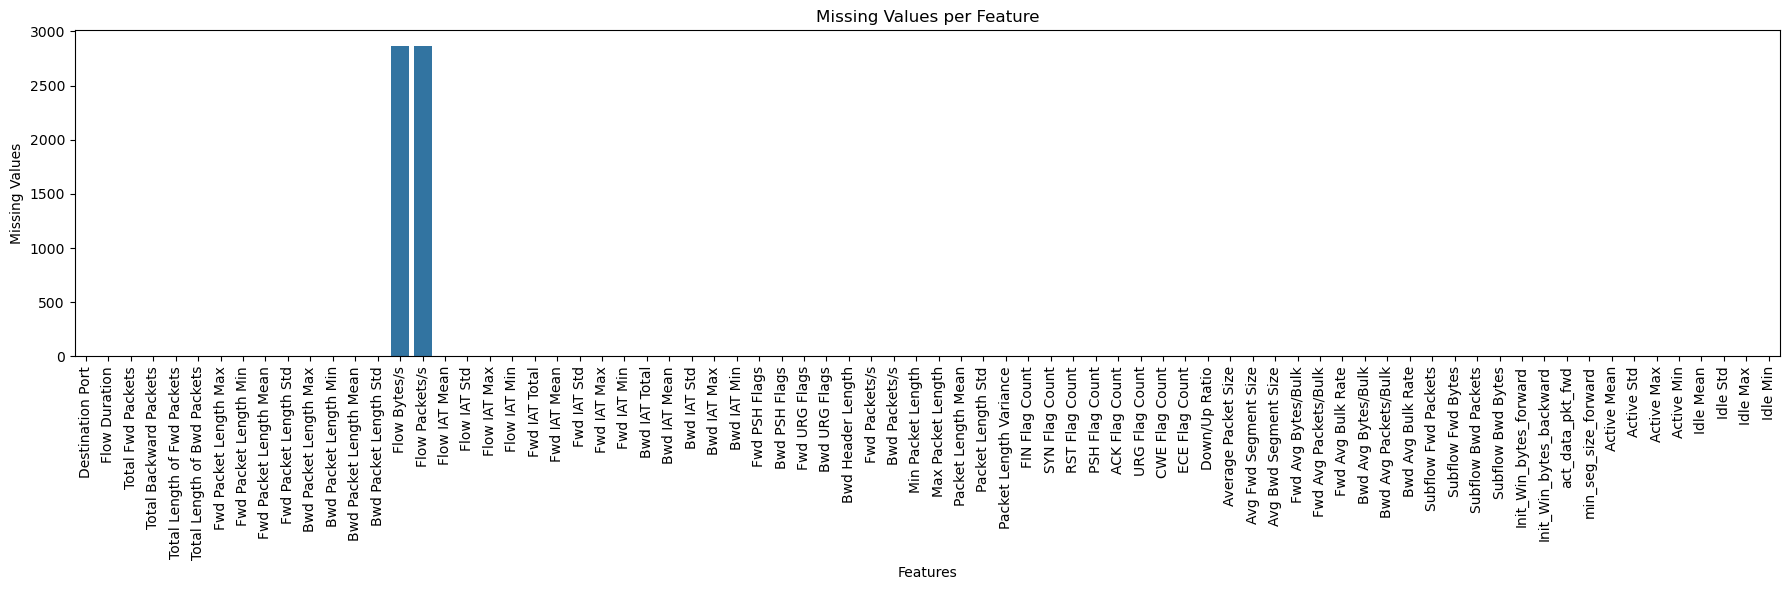

In [7]:
# Hitung missing values per kolom
missing_values = df.select([
    count(when(
        col(c).isNull() |                     
        isnan(col(c)) |                       
        (col(c) == "") |                      
        (col(c) == float("inf")) |            
        (col(c) == float("-inf")) ,                        
        c
    )).alias(c)
    for c in df.columns
    if dict(df.dtypes)[c] in ['int', 'double', 'float', 'long']
]).toPandas().T


#visualisasi mising value
def plotMissingValues(missing_values):
    plt.figure(figsize=(18, 6))
    sns.barplot(
        x=missing_values.index,
        y=missing_values[0]
    )
    plt.xticks(rotation=90)
    plt.xlabel("Features")       
    plt.ylabel("Missing Values")   
    plt.title("Missing Values per Feature")
    plt.tight_layout()
    plt.show()


plotMissingValues(missing_values)


In [8]:
from pyspark.sql.functions import col, isnan

cond_bytes = (
    isnan(col("Flow Bytes/s")) | 
    col("Flow Bytes/s").isNull() | 
    (col("Flow Bytes/s") == float("inf"))|
    (col("Flow Packets/s") == float("-inf"))
)

cond_packets = (
    isnan(col("Flow Packets/s")) | 
    col("Flow Packets/s").isNull() | 
    (col("Flow Packets/s") == float("inf"))|
    (col("Flow Packets/s") == float("-inf"))
)

num_missing = df.filter(cond_bytes | cond_packets)

print(f"Jumlah baris bermasalah (di Flow Bytes/s ATAU Flow Packets/s): {num_missing.count()}")

print("\n=== Detail Label yang Bermasalah ===")
num_missing.select("Label", "BinaryLabel").groupBy("Label").count().show()

Jumlah baris bermasalah (di Flow Bytes/s ATAU Flow Packets/s): 2867

=== Detail Label yang Bermasalah ===


[Stage 15:===============================================>        (11 + 2) / 13]

+-----------+-----+
|      Label|count|
+-----------+-----+
|     BENIGN| 1777|
|       DDoS|    2|
|   PortScan|  126|
|FTP-Patator|    3|
|   DoS Hulk|  949|
|        Bot|   10|
+-----------+-----+



In [9]:
# Melakukan Imputasi
target_columns = ["Flow Bytes/s", "Flow Packets/s"]

def impute_column(df, column_name):
    print(f"\nProcessing Column: {column_name}...")

    # Pastikan tipe double
    df = df.withColumn(column_name, col(column_name).cast("double"))

    # Hitung mean dari data bersih
    stats = df.filter(
        col(column_name).isNotNull() & 
        ~isnan(col(column_name)) & 
        (col(column_name) != float('inf')) & 
        (col(column_name) != float('-inf'))
    ).agg(mean(column_name).alias("avg_val")).collect()

    mean_val = stats[0]["avg_val"] or 0.0
    print(f" -> Mean digunakan: {mean_val}")

    # Imputasi NaN, Null, Inf, -Inf
    df = df.withColumn(
        column_name,
        when(
            col(column_name).isNull() | 
            isnan(col(column_name)) | 
            (col(column_name) == float('inf')) | 
            (col(column_name) == float('-inf')),
            lit(mean_val)
        ).otherwise(col(column_name))
    )

    # Verifikasi sisa error
    remaining = df.filter(
        col(column_name).isNull() | 
        isnan(col(column_name)) | 
        (col(column_name) == float('inf')) | 
        (col(column_name) == float('-inf'))
    ).count()

    print(f" -> Sisa Error (NaN/Inf/Null) di {column_name}: {remaining}")
    return df

print("--- Memulai Imputasi untuk Flow Bytes & Flow Packets ---")
for c in target_columns:
    df = impute_column(df, c)

--- Memulai Imputasi untuk Flow Bytes & Flow Packets ---

Processing Column: Flow Bytes/s...


 -> Mean digunakan: 1491719.0643420462


 -> Sisa Error (NaN/Inf/Null) di Flow Bytes/s: 0

Processing Column: Flow Packets/s...


 -> Mean digunakan: 70854.23306263573


[Stage 27:===============================================>        (11 + 2) / 13]

 -> Sisa Error (NaN/Inf/Null) di Flow Packets/s: 0


In [10]:
from pyspark.sql.functions import col

print("--- Memeriksa Kolom Zero Variance ---")

total_rows = df.count()
columns_to_drop = []

for c in df.columns:
    dtype = dict(df.dtypes)[c]
    if dtype in ['int', 'double', 'float', 'long', 'bigint']:
        zero_count = df.filter(col(c) == 0).count()
        if zero_count == total_rows:
            print(f"Menandai kolom untuk dihapus: {c}")
            columns_to_drop.append(c)

if columns_to_drop:
    df = df.drop(*columns_to_drop)
    print(f"Berhasil menghapus {len(columns_to_drop)} kolom.")
else:
    print("Tidak ada kolom yang 100% nol.")

print(f"Jumlah kolom sekarang: {len(df.columns)}")


--- Memeriksa Kolom Zero Variance ---


Menandai kolom untuk dihapus: Bwd PSH Flags


Menandai kolom untuk dihapus: Bwd URG Flags


Menandai kolom untuk dihapus: Fwd Avg Bytes/Bulk


Menandai kolom untuk dihapus: Fwd Avg Packets/Bulk


Menandai kolom untuk dihapus: Fwd Avg Bulk Rate


Menandai kolom untuk dihapus: Bwd Avg Bytes/Bulk


Menandai kolom untuk dihapus: Bwd Avg Packets/Bulk


Menandai kolom untuk dihapus: Bwd Avg Bulk Rate


[Stage 264:==========================================>            (10 + 3) / 13]

Berhasil menghapus 8 kolom.
Jumlah kolom sekarang: 72


In [11]:
# Daftar kolom yang akan dihapus
for c in ["Fwd Header Length55", "Label"]:
    if c in df.columns:
        df = df.drop(c)

print(f"Total kolom tersisa: {len(df.columns)}")


Total kolom tersisa: 70


# Data Preprocessing

In [12]:
# Mengubah BinaryLabel menjadi numerik 0 dan 1
df = df.withColumn(
    "BinaryLabel",
    when(col("BinaryLabel") == "Normal", 0)
    .when(col("BinaryLabel") == "Attack", 1)
)

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)
                                                                                

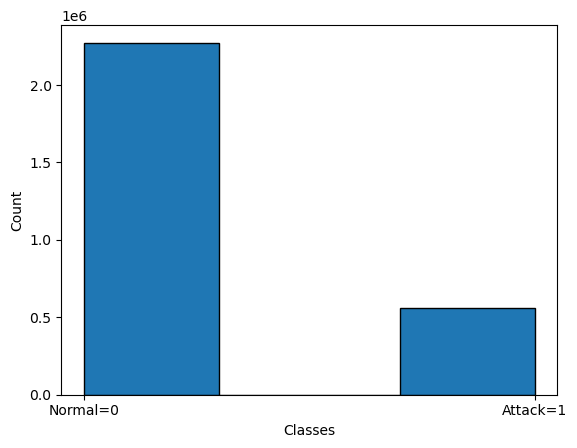

In [14]:
binary_label_pd = df.select("BinaryLabel").toPandas()["BinaryLabel"]

# Plot histogram
plt.hist(binary_label_pd, bins=[0, 0.3, 0.7, 1], edgecolor='black')
plt.xticks([0, 1], labels=['Normal=0', 'Attack=1'])
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

In [15]:
# Resample
# Pisahkan kelas mayoritas dan minoritas
df_majority = df.filter(col("BinaryLabel") == 0)
df_minority = df.filter(col("BinaryLabel") == 1)

# Hitung jumlah baris minoritas
n_minority = df_minority.count()
n_majority = df_majority.count()

# Hitung proporsi untuk sample mayoritas agar seimbang
fraction = n_minority / n_majority

# Lakukan undersampling pada mayoritas
df_majority_undersampled = df_majority.sample(withReplacement=False, fraction=fraction, seed=42)

# Gabungkan dengan minoritas
df_balanced = df_majority_undersampled.union(df_minority)

# Verifikasi distribusi
df_balanced.groupBy("BinaryLabel").count().show()
print(f"Total Baris Baru: {df_balanced.count():,}")


+-----------+------+
|BinaryLabel| count|
+-----------+------+
|          0|557643|
|          1|557646|
+-----------+------+



[Stage 278:================================================>      (23 + 3) / 26]

Total Baris Baru: 1,115,289


In [16]:
# PEMILIHAN FEATURE
# Gunakan df_balanced sebagai dataset
df = df_balanced

# Tentukan target
target_column = "BinaryLabel"

# Fitur (semua kolom kecuali target)
feature_columns = [c for c in df.columns if c != target_column]


In [17]:
# STANDARDIZATION
cols_no_scale = [
    'Destination Port', 
    'Fwd PSH Flags', 'Fwd URG Flags', 
    'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 
    'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count'
]


numeric_cols_to_scale = [
    f.name for f in df.schema.fields  
    if f.dataType.typeName() in ['integer', 'double', 'long'] 
    and f.name not in cols_no_scale
    and f.name != "BinaryLabel" 
]

print(f"DEBUG: Jumlah kolom yang akan diskalakan: {len(numeric_cols_to_scale)}")

# Stage 1: Satukan kolom yang diskalakan
assembler = VectorAssembler(inputCols=numeric_cols_to_scale, outputCol="features_to_scale", handleInvalid="skip")
# Stage 2: StandardScaler
scaler = StandardScaler(inputCol="features_to_scale", outputCol="scaled_features", withMean=True, withStd=True)
# Stage 3: Gabungkan hasil scale dengan kolom yang TIDAK diskalakan
final_assembler = VectorAssembler(inputCols=["scaled_features"] + cols_no_scale, outputCol="features")

# Pipeline Preprocessing
pipeline_prep = Pipeline(stages=[assembler, scaler, final_assembler])

# Terapkan pipeline ke DataFrame UTUH (df)
pipeline_model = pipeline_prep.fit(df)
df_final = pipeline_model.transform(df)

# Cache dan hitung untuk eksekusi
df_final = df_final.cache()
df_final.count()

print("Data Preprocessing Selesai. Data siap!")

DEBUG: Jumlah kolom yang akan diskalakan: 58


[Stage 284:====================================================>  (25 + 1) / 26]

Data Preprocessing Selesai. Data siap!


In [18]:
# DATA SPLITTING

# Split data (70% train, 30% test)
train_df, test_df = df_final.randomSplit([0.7, 0.3], seed=42)

print(f"Jumlah Total Data Latih (Train): {train_df.count():,}")
print(f"Jumlah Total Data Uji (Test): {test_df.count():,}")


Jumlah Total Data Latih (Train): 781,349


[Stage 291:====================================================>  (25 + 1) / 26]

Jumlah Total Data Uji (Test): 333,940


# Modeling

## Random Forest

In [19]:
# Inisialisasi Random Forest
rf = RandomForestClassifier(
    featuresCol="features", 
    labelCol="BinaryLabel", 
    numTrees=50, 
    seed=42
)

# Latih model
rf_model = rf.fit(train_df)

# Prediksi
rf_pred = rf_model.transform(test_df)

[Stage 299:>                                                      (0 + 12) / 26]

[866.875s][warning][gc,alloc] Executor task launch worker for task 0.0 in stage 299.0 (TID 1543): Retried waiting for GCLocker too often allocating 1048576 words


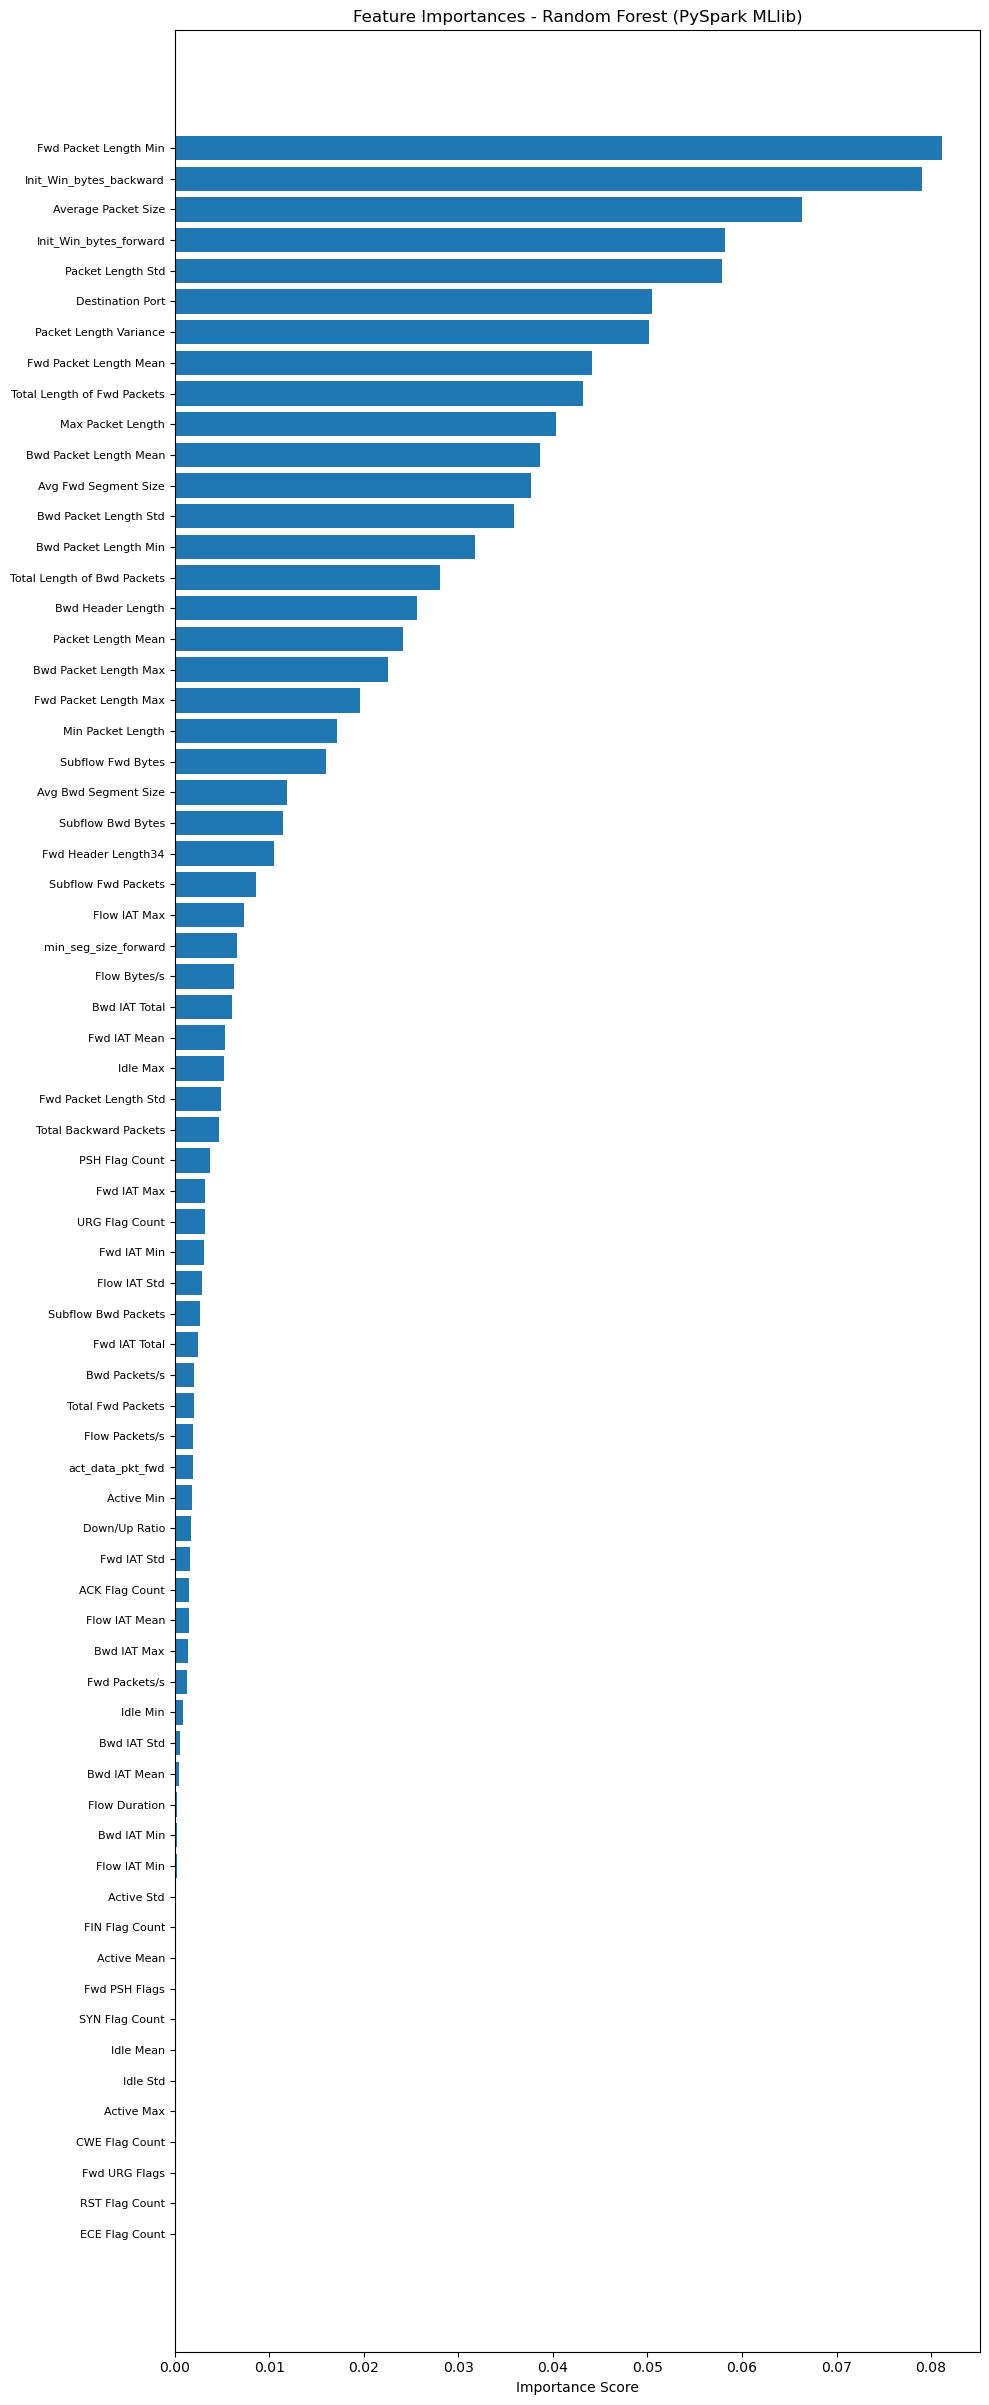

In [24]:
importances = rf_model.featureImportances.toArray()
feature_names = numeric_cols_to_scale + cols_no_scale

indices = np.argsort(importances)[::1]
sorted_importances = importances[indices]
sorted_feature_names = [feature_names[i] for i in indices]

plt.figure(figsize=(10, len(feature_names)*0.35))
plt.barh(range(len(importances)), sorted_importances, align="center")
plt.yticks(range(len(importances)), sorted_feature_names, fontsize=8)
plt.xlabel("Importance Score")
plt.title("Feature Importances - Random Forest (PySpark MLlib)")
plt.tight_layout()
plt.show()


### Model Evaluation


Random Forest Metrics:
Accuracy: 0.9603
F1 Score: 0.9606
Precision: 0.9539
Recall: 0.9674

Classification Report:
               precision    recall  f1-score   support

           0     0.9668    0.9531    0.9599    166716
           1     0.9539    0.9674    0.9606    167224

    accuracy                         0.9603    333940
   macro avg     0.9604    0.9602    0.9602    333940
weighted avg     0.9603    0.9603    0.9602    333940



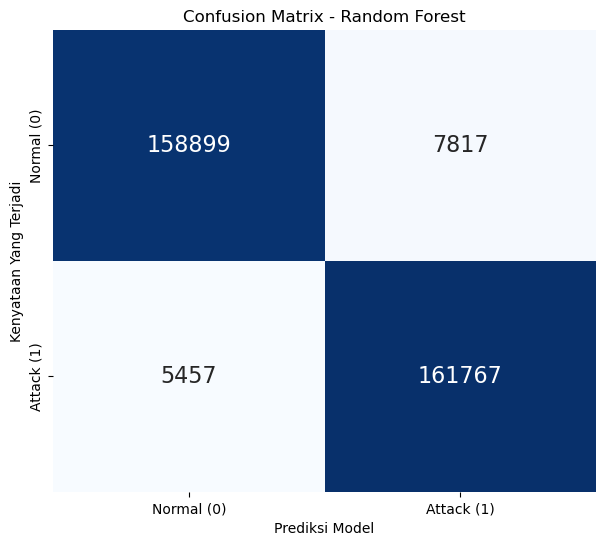

In [26]:
# Ambil label asli dan prediksi dari DataFrame prediksi
y_true = rf_pred.select("BinaryLabel").rdd.flatMap(lambda x: x).collect()
y_pred = rf_pred.select("prediction").rdd.flatMap(lambda x: x).collect()

# Fungsi untuk membuat confusion matrix dengan heatmap
def plot_confusion_matrix(y_true, y_pred, classes, title):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Hitung persentase per kelas
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_percent, annot=cm, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes,
                annot_kws={"fontsize":16}, cbar=False) 
    plt.title(title)
    plt.xlabel('Prediksi Model')
    plt.ylabel('Kenyataan Yang Terjadi')
    plt.show()

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report

# Hitung metrik evaluasi utama
rf_accuracy = accuracy_score(y_true, y_pred)
rf_f1 = f1_score(y_true, y_pred)
rf_recall = recall_score(y_true, y_pred)
rf_precision = precision_score(y_true, y_pred)

# Cetak hasil evaluasi
print('\nRandom Forest Metrics:')
print(f'Accuracy: {rf_accuracy:.4f}')
print(f'F1 Score: {rf_f1:.4f}')
print(f'Precision: {rf_precision:.4f}')
print(f'Recall: {rf_recall:.4f}')
print('\nClassification Report:\n', classification_report(y_true, y_pred, digits=4))

# Plot confusion matrix
classes = ['Normal (0)', 'Attack (1)']
plot_confusion_matrix(y_true, y_pred, classes, 'Confusion Matrix - Random Forest')
